# Load libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

sns.set_context('paper', font_scale=2) # set some nice global plotting settings


# Read in data
Make sure to use the raw **counts matrix** csv file.

In [46]:
df = pd.read_csv('data/fshd_counts_matrix.csv', index_col = 0)

In [47]:
df.head()

,C_3_1,C_3_2,C_5_1,C_5_2,F_3_1,F_3_2,F_5_1,F_5_2
DDX11L1,3.0,0.0,4.0,1.0,25.0,0.0,0.0,19.0
WASH7P,22.0,17.0,25.0,17.0,16.0,3.0,18.0,7.0
MIR6859-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIR1302-2HG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIR1302-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Read in metadata

In [48]:
metadata = pd.read_csv('data/fshd_metadata.csv')
metadata = metadata[metadata['Sample'].isin(df.columns)]

metadata.index = metadata['Sample'] # metadata index must be column names of the data

In [49]:
metadata.head()

,SampleID,Sample,Timepoint,Condition,Replicate
Sample,,,,,
C_3_1,Control-1 Day 3 Rep 1,C_3_1,Day_3,Control,1
C_3_2,Control-1 Day 3 Rep 2,C_3_2,Day_3,Control,2
C_5_1,Control-1 Day 5 Rep 1,C_5_1,Day_5,Control,1
C_5_2,Control-1 Day 5 Rep 2,C_5_2,Day_5,Control,2
F_3_1,FSHD2-1 Day 3 Rep 1,F_3_1,Day_3,FSHD,1


# Define filters and group

In [55]:
filtering = {'Condition': ['Control'],
             'Timepoint': ['Day_3','Day_5']}

group = 'Timepoint' # change to the group you're interested in making the comparison in


In [56]:
metadata_selected = metadata.copy()
for col in filtering.keys():
    metadata_selected = metadata_selected[metadata_selected[col].isin(filtering[col])]

df_selected = df.loc[:, metadata_selected['Sample']]


# Run PyDESeq2
See package documedf_selectedntation [here](https://pydeseq2.readthedocs.io/en/latest/).

In [57]:
dds = DeseqDataSet(
    counts=df_selected.T,
    clinical=metadata_selected,
    design_factors=group,
    refit_cooks=True
)
dds.deseq2()
stat_res = DeseqStats(dds, 
                      contrast=[group] + filtering[group])
stat_res.summary()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 15.43 seconds.

Fitting dispersion trend curve...
... done in 17.49 seconds.

Fitting MAP dispersions...
... done in 11.88 seconds.

Fitting LFCs...
... done in 3.78 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 8.78 seconds.

Log2 fold change & Wald test p-value: Timepoint Day_3 vs Day_5


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
DDX11L1,2.081340,-0.909322,1.910474,-0.475967,0.634098,NaN
WASH7P,20.371162,-0.325099,0.586397,-0.554401,0.579305,0.747450
MIR6859-1,0.000000,NaN,NaN,NaN,NaN,NaN
MIR1302-2HG,0.000000,NaN,NaN,NaN,NaN,NaN
MIR1302-2,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
AC240274.1,122.205833,0.593113,0.152971,3.877294,0.000106,0.000585
RF00003_14,0.000000,NaN,NaN,NaN,NaN,NaN
RF00003_15,0.000000,NaN,NaN,NaN,NaN,NaN
AC213203.2,1.192229,1.773730,2.516811,0.704753,0.480964,NaN


# Format results 

In [58]:
results = stat_res.results_df # get results df

results['nlog10padj'] = -np.log10(results['padj']) # make -log10(adj. p-value) column

results.replace([np.inf, -np.inf], np.nan, inplace=True) # remove NAN and infinity values...

results = results.dropna() # drop NAs

results = results.reset_index().rename(columns={'index': 'gene_name'}) # set gene name to be its own column


/opt/apps/python/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Volcano plot 


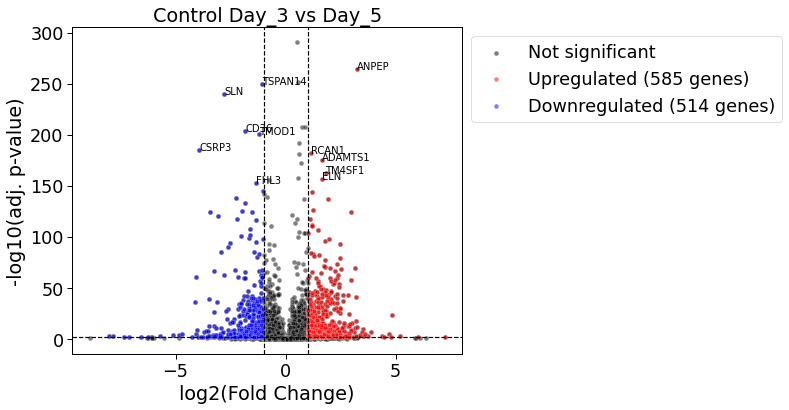

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scip

In [62]:
degs_up = results[(results['padj'] < 0.05) & (results['log2FoldChange'] > 1)]
degs_down = results[(results['padj'] < 0.05) & (results['log2FoldChange'] < -1)]


plt.figure(figsize=(7, 6))
sns.scatterplot(data=results, x='log2FoldChange', y='nlog10padj', alpha=0.5, 
                color='black', label = "Not significant")

# basically layer the subset dataframes on top of the original plot
sns.scatterplot(data=degs_up, x='log2FoldChange', y='nlog10padj', alpha=0.5, 
                color='red', label = f"Upregulated ({len(degs_up)} genes)")
sns.scatterplot(data=degs_down, x='log2FoldChange', y='nlog10padj', alpha=0.5, 
                color='blue', label = f"Downregulated ({len(degs_down)} genes)")

plt.xlabel('log2(Fold Change)')
plt.ylabel('-log10(adj. p-value)')
plt.title('Control Day_3 vs Day_5')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') # move legend

# draw horizontal and vertical dashed lines
plt.axhline(1.3, color='black', linestyle='--')
plt.axvline(1, color='black', linestyle='--')
plt.axvline(-1, color='black', linestyle='--')

# label specific points
for index, row in results.iterrows():
    if abs(row['log2FoldChange']) > 1 and row['nlog10padj'] > 150:
        plt.text(row['log2FoldChange'], row['nlog10padj'], row['gene_name'], fontsize=10)


plt.show()
